In [1]:
# **Import Libraries**
import os
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

In [2]:
# **Read Data**
data = pd.read_csv("../Music from kaggle/dataset/data.csv")
genre_data = pd.read_csv('../Music from kaggle/dataset/data_by_genres.csv')
year_data = pd.read_csv('../Music from kaggle/dataset/data_by_year.csv')
print(data.info())
print(genre_data.info())
print(year_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

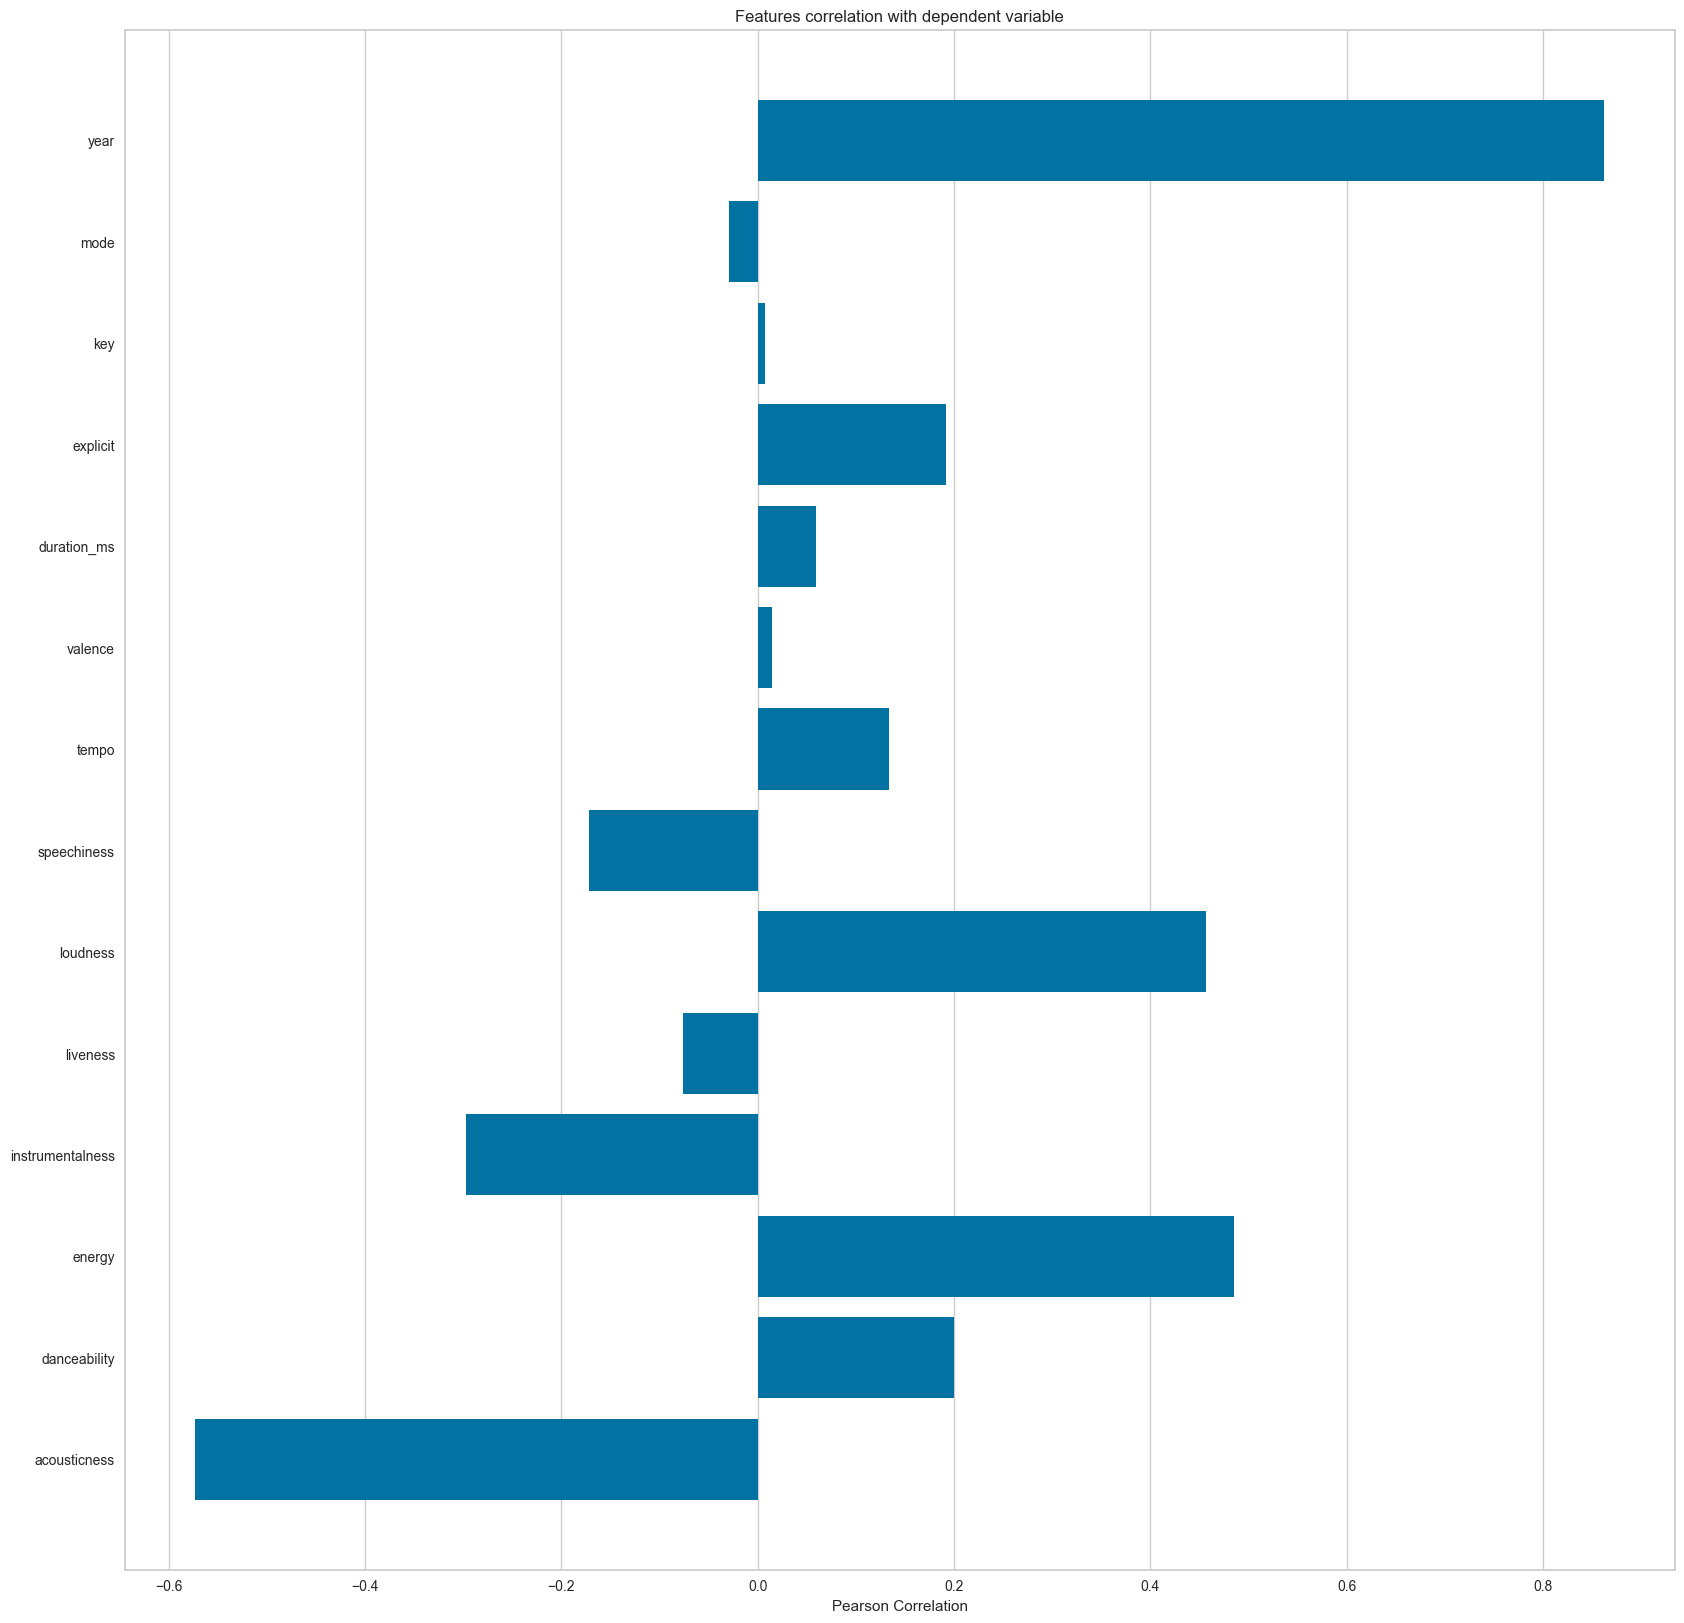

<Axes: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [3]:
# **Feature Correlation**
from yellowbrick.target import FeatureCorrelation

feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms','explicit','key','mode','year']

X, y = data[feature_names], data['popularity']

# Create a list of the feature names
features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(20,20)
visualizer.fit(X, y)     # Fit the data to the visualizer
visualizer.show()

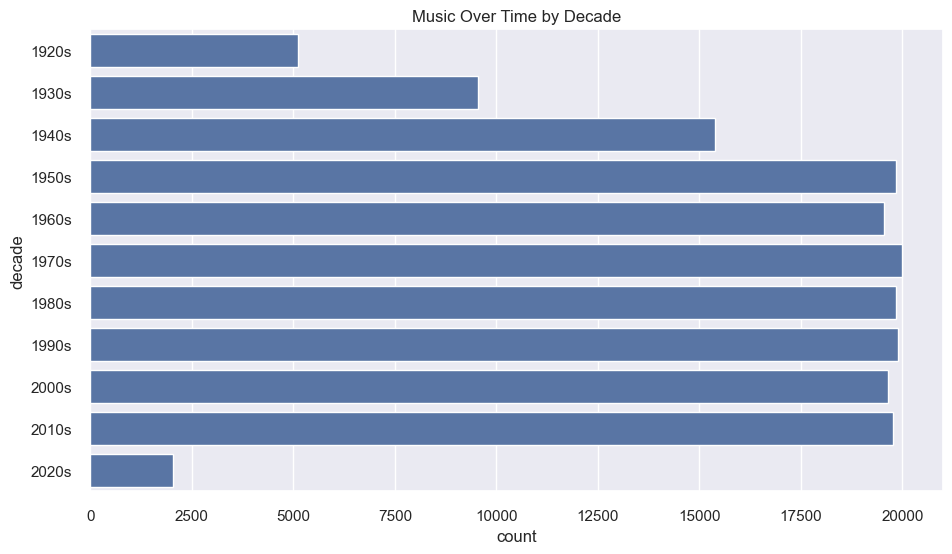

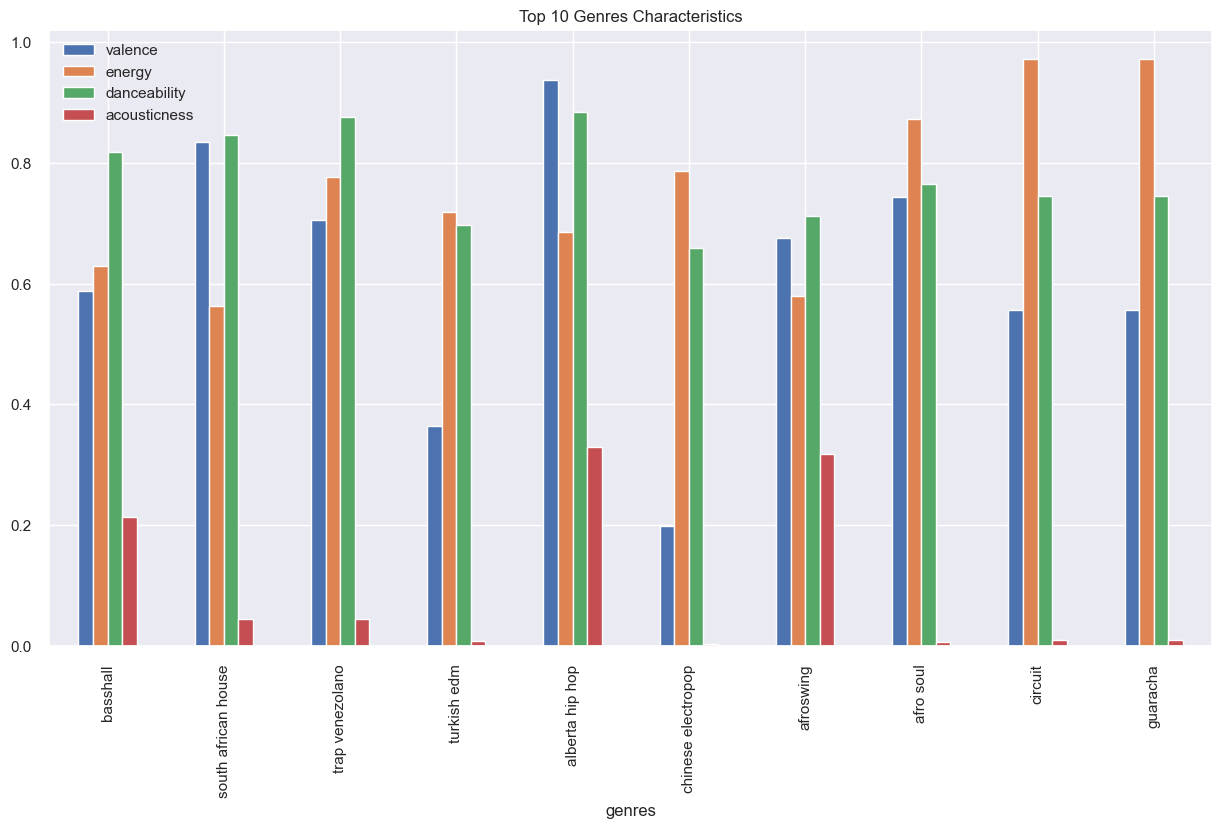

In [4]:
# **Data Understanding by Visualization and EDA**
# **Music Over Time**
import seaborn as sns
import matplotlib.pyplot as plt

# Music Over Time
def get_decade(year):
    period_start = int(year / 10) * 10
    decade = '{}s'.format(period_start)
    return decade

data['decade'] = data['year'].apply(get_decade)
sns.set(rc={'figure.figsize': (11, 6)})
sns.countplot(data['decade'])
plt.title('Music Over Time by Decade')
plt.show()

# Characteristics of Different Genres
top10_genres = genre_data.nlargest(10, 'popularity')
fig, ax = plt.subplots(figsize=(15, 8))
top10_genres.plot(kind='bar', x='genres', y=['valence', 'energy', 'danceability', 'acousticness'], ax=ax)
plt.title('Top 10 Genres Characteristics')
plt.show()


In [5]:
# Define the clustering pipeline
cluster_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('kmeans', KMeans(n_clusters=10))
])

# Select numerical columns from genre_data
X = genre_data.select_dtypes(np.number)

# Fit the pipeline
cluster_pipeline.fit(X)

# Predict the clusters
genre_data['cluster'] = cluster_pipeline.predict(X)

In [6]:
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd

# Define the t-SNE pipeline
tsne_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('tsne', TSNE(n_components=2, verbose=1))
])

# Fit and transform the data
genre_embedding = tsne_pipeline.fit_transform(X)

# Create a DataFrame for the projection
projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
projection['genres'] = genre_data['genres']
projection['cluster'] = genre_data['cluster']

# Plot the projection
fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genres']
)
fig.write_html('genre_clusters.html')

# To automatically open the saved HTML file, uncomment the following line
# import webbrowser
# webbrowser.open('genre_clusters.html')


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2973 samples in 0.007s...
[t-SNE] Computed neighbors for 2973 samples in 0.281s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2973
[t-SNE] Computed conditional probabilities for sample 2000 / 2973
[t-SNE] Computed conditional probabilities for sample 2973 / 2973
[t-SNE] Mean sigma: 0.777516
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.102425
[t-SNE] KL divergence after 1000 iterations: 1.393660


In [7]:
#Clustering Songs with K-Means
# Define the song clustering pipeline

song_cluster_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('kmeans', KMeans(n_clusters=20, verbose=False))
])

# Select numerical columns from data
X = data.select_dtypes(np.number)

# Fit the pipeline
song_cluster_pipeline.fit(X)

# Predict the clusters
song_cluster_labels = song_cluster_pipeline.predict(X)
data['cluster_label'] = song_cluster_labels


Visualizing the Clusters with PCA

In [8]:
from sklearn.decomposition import PCA

# Define the PCA pipeline
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('PCA', PCA(n_components=2))
])

# Fit and transform the data
song_embedding = pca_pipeline.fit_transform(X)

# Create a DataFrame for the projection
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = data['name']
projection['cluster'] = data['cluster_label']

# Plot the projection
fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title']
)
fig.write_html('song_clusters.html')

# To automatically open the saved HTML file, uncomment the following line
# import webbrowser
# webbrowser.open('song_clusters.html')


In [9]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
from collections import defaultdict
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler

# Spotify API credentials
CLIENT_ID = '380a6b3535dc420a905dccf328a0e165'
CLIENT_SECRET = 'b0ca7947448246d28aafc40f49610cf4'
REDIRECT_URI = 'http://localhost:8888/callback'

# Authenticate with user permission
scope = 'user-top-read user-library-read user-read-recently-played'
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=CLIENT_ID,
                                               client_secret=CLIENT_SECRET,
                                               redirect_uri=REDIRECT_URI,
                                               scope=scope))

def find_song(name, year):
    song_data = defaultdict()
    results = sp.search(q=f'track: {name} year: {year}', limit=1)
    if not results['tracks']['items']:
        return None

    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]

    song_data['name'] = [name]
    song_data['year'] = [year]
    song_data['explicit'] = [int(results['explicit'])]
    song_data['duration_ms'] = [results['duration_ms']]
    song_data['popularity'] = [results['popularity']]
    song_data['artists'] = [', '.join(artist['name'] for artist in results['artists'])]

    for key, value in audio_features.items():
        song_data[key] = value

    return pd.DataFrame(song_data)

number_cols = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
               'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']

def get_mean_vector(song_list):
    song_vectors = []
    for song in song_list:
        song_data = find_song(song['name'], song['year'])
        if song_data is None:
            print(f'Warning: {song["name"]} does not exist in Spotify')
            continue
        song_vector = song_data[number_cols].values
        song_vectors.append(song_vector)
    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)

def flatten_dict_list(dict_list):
    flattened_dict = defaultdict(list)
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)
    return flattened_dict

def recommend_songs(song_list, n_songs=10):
    song_dict = flatten_dict_list(song_list)
    song_center = get_mean_vector(song_list)
    spotify_data = get_all_spotify_data()
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(spotify_data[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])
    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[['name', 'year', 'artists']].to_dict(orient='records')

def get_all_spotify_data():
    results = sp.current_user_saved_tracks(limit=50)
    tracks = results['items']
    spotify_data = []
    for item in tracks:
        track = item['track']
        track_id = track['id']
        audio_features = sp.audio_features(track_id)[0]
        song_data = {
            'name': track['name'],
            'year': int(track['album']['release_date'][:4]),
            'explicit': int(track['explicit']),
            'duration_ms': track['duration_ms'],
            'popularity': track['popularity'],
            'artists': ', '.join(artist['name'] for artist in track['artists'])
        }
        song_data.update(audio_features)
        spotify_data.append(song_data)
    return pd.DataFrame(spotify_data)

# **Mood-Based Recommendation System**
def get_mood_recommendations(mood, n_songs=10):
    mood_features = {
        'happy': {'valence': (0.5, 1.0), 'energy': (0.5, 1.0)},
        'sad': {'valence': (0.0, 0.5), 'energy': (0.0, 0.5)},
        'energetic': {'energy': (0.7, 1.0)}
    }
    spotify_data = get_all_spotify_data()
    mood_data = spotify_data.copy()
    for feature, (low, high) in mood_features[mood].items():
        mood_data = mood_data[(mood_data[feature] >= low) & (mood_data[feature] <= high)]
    return mood_data.sample(n=n_songs)[['name', 'year', 'artists']].to_dict(orient='records')

# **Generalized Playlists**
def get_generalized_playlists(playlist_type='top_hits', n_songs=10):
    spotify_data = get_all_spotify_data()
    if playlist_type == 'top_hits':
        return spotify_data.nlargest(n_songs, 'popularity')[['name', 'year', 'artists']].to_dict(orient='records')
    elif playlist_type == 'genre':
        top_genres = spotify_data['genres'].value_counts().index[:10]
        genre_playlists = {}
        for genre in top_genres:
            genre_playlists[genre] = spotify_data[spotify_data['genres'] == genre].nlargest(n_songs, 'popularity')[['name', 'year', 'artists']].to_dict(orient='records')
        return genre_playlists

# Example Usage
user_songs = [{'name': 'Come As You Are', 'year':1991},
              {'name': 'Smells Like Teen Spirit', 'year': 1991},
              {'name': 'Lithium', 'year': 1992},
              {'name': 'All Apologies', 'year': 1993},
              {'name': 'Stay Away', 'year': 1993}]

print("Personalized Recommendations:")
print(recommend_songs(user_songs))

print("Mood-Based Recommendations (sad):")
print(get_mood_recommendations('sad'))

print("Generalized Playlists (Top Hits):")
print(get_generalized_playlists('top_hits'))


Personalized Recommendations:
[{'name': 'Tainu Leke', 'year': 2007, 'artists': 'Sonu Nigam, Mahalakshmi Iyer'}, {'name': 'Na Tum Jano Na Hum', 'year': 2000, 'artists': 'Lucky Ali, Ramya'}, {'name': 'Main Sharabi', 'year': 2012, 'artists': 'Imran Aziz Mian, Yo Yo Honey Singh, Pritam'}, {'name': 'Satisfya', 'year': 2013, 'artists': 'Imran Khan'}, {'name': 'Do Dhaari Talwaar', 'year': 2011, 'artists': 'Sohail Sen, Shahid Mallya, Shweta Pandit, Irshad Kamil'}, {'name': 'Dil Ne Dil Ko Pukara', 'year': 2000, 'artists': 'Babul Supriyo'}, {'name': 'Shakira', 'year': 2015, 'artists': 'Shalmali Kholgade'}, {'name': 'Mat Aazma Re (From "Murder 3")', 'year': 2013, 'artists': 'Pritam, KK'}, {'name': 'Saadi Galli Aaja', 'year': 2017, 'artists': 'Ayushmann Khurrana, Neeti Mohan'}, {'name': 'Ik Kahani', 'year': 2017, 'artists': 'Gajendra Verma'}]
Mood-Based Recommendations (sad):
[{'name': 'Raghunandana (From "HanuMan") [Hindi]', 'year': 2024, 'artists': 'GowraHari, Saicharan Bhaskaruni, Lokeshwar Eda